<a href="https://colab.research.google.com/github/oisincam/quantum_circuits/blob/main/Stim_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction


This notebook is a place where I test out and explain various features of the stim quantum circuit simulator library. Is is very informal, only intended to be read by me.

#Imports

In [53]:
!pip install stim~=1.14

In [54]:
import stim
import random
from math import comb

#Adding Gates to circuits

First define a circuit. We then add gates, by specifying the gate, and then the qubit. We don't need to predefine the qubits, it will add them as needed.

In [ ]:
circuit = stim.Circuit()

In [ ]:
circuit.append("H", [0])


In [ ]:
circuit.diagram()

q0: -H-

Let's continue, and make a Bell state.

In [ ]:
circuit.append("CNOT", [0, 1])


In [ ]:
circuit.diagram()

q0: -H-@-
       |
q1: ---X-

The output of this circuit is a Bell state. Let's add a measurement in the computational basis at the end:


In [ ]:
circuit.append("M", [0, 1])
circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

We can even make it pretty with SVG:


In [ ]:
circuit.diagram('timeline-svg-html')

<svg viewBox="0 0 288 224"  version="1.1" xmlns="http://www.w3.org/2000/svg">
<g id="qubit_lines">
<path id="qubit_line:0" d="M64,64 L256,64 " stroke="black"/>
<text dominant-baseline="central" text-anchor="end" font-family="monospace" font-size="12" x="64" y="64">q0</text>
<path id="qubit_line:1" d="M64,128 L256,128 " stroke="black"/>
<text dominant-baseline="central" text-anchor="end" font-family="monospace" font-size="12" x="64" y="128">q1</text>
</g>
<rect x="80" y="48" width="32" height="32" stroke="black" fill="white"/>
<text dominant-baseline="central" text-anchor="middle" font-family="monospace" font-size="30" x="96" y="64">H</text>
<path d="M160,64 L160,128 " stroke="black"/>
<circle cx="160" cy="64" r="12" stroke="none" fill="black"/>
<circle cx="160" cy="128" r="12" stroke="black" fill="white"/>
<path d="M148,128 L172,128 M160,116 L160,140 " stroke="black"/>
<rect x="208" y="48" width="32" height="32" stroke="black" fill="black"/>
<text dominant-baseline="central" text-anchor="middle" font-family="monospace" font-size="30" x="224" y="64" fill="white">M</text>
<text text-anchor="middle" font-family="monospace" font-size="8" x="224" y="44">rec[0]</text>
<rect x="208" y="112" width="32" height="32" stroke="black" fill="black"/>
<text dominant-baseline="central" text-anchor="middle" font-family="monospace" font-size="30" x="224" y="128" fill="white">M</text>
<text text-anchor="middle" font-family="monospace" font-size="8" x="224" y="108">rec[1]</text>
</svg>

#Running a Circuit

The output of a quantum circuit is probabilistic; we refer to running the circuit as "sampling from the circuit".

In [ ]:
sampler = circuit.compile_sampler()
1*sampler.sample(shots=10)

array([[0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0]])

So, we always see either  state 00 or 11, with equal probability.

#Simulating Noise

Let's make a circuit that prepares the |0> state, then has a 20% chance of having an X error.

In [ ]:
circuit = stim.Circuit("""
    TICK
    X_ERROR(0.267) 0
    TICK

    M 0
""")

In [ ]:
circuit.diagram()

q0: ---X_ERROR(0.267)-M:rec[0]-

In [ ]:
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))
#let us take a large number of shots and calculate the proportion that are the 1 state.
output=1*sampler.sample(shots=1000000)
print(output.sum()/1000000)

[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]]
0.267142


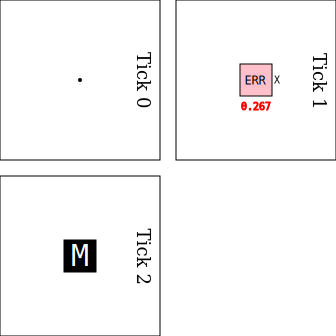

In [ ]:
circuit.diagram('timeslice-svg')

We can also use the append function again:

In [ ]:
circuit=stim.Circuit()
circuit.append("X_ERROR", [0], 0.2)
circuit.append('M',0)
circuit.diagram()

q0: -X_ERROR(0.2)-M:rec[0]-

In [ ]:
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))
#let us take a large number of shots and calculate the proportion that are the 1 state.
output=1*sampler.sample(shots=1000000)
print(output.sum()/1000000)

[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
0.200108


#Measuring Stabilizers


Let's look at how we can implement the measurement of stabilizer operators, with ancillas on the bottom.


##Single Qubit operators

We prepare the state 0 and measure Z:

In [ ]:
circuit = stim.Circuit()
circuit.append('H', [1])
circuit.append('CZ', [1,0])
circuit.append('H', [1])
circuit.append('M', [1])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: ---@------------
       |
q1: -H-@-H-M:rec[0]-
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


We prepare the state 1 and measure Z:

In [ ]:
circuit = stim.Circuit()
circuit.append('X', [0])
circuit.append('H', [1])
circuit.append('CZ', [1,0])
circuit.append('H', [1])
circuit.append('M', [1])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: -X-@------------
       |
q1: -H-@-H-M:rec[0]-
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


We prepare the state 0 and measure X:

In [ ]:
circuit = stim.Circuit()
circuit.append('H', [1])
circuit.append('CX', [1,0])
circuit.append('H', [1])
circuit.append('M', [1])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: ---X------------
       |
q1: -H-@-H-M:rec[0]-
[[0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]]


We prepare the state + and measure X

In [ ]:
circuit = stim.Circuit()
circuit.append('H', [0])
circuit.append('H', [1])
circuit.append('CX', [1,0])
circuit.append('H', [1])
circuit.append('M', [1])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: -H-X------------
       |
q1: -H-@-H-M:rec[0]-
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


We prepare the state - and measure X

In [ ]:
circuit = stim.Circuit()
circuit.append('X',[0])
circuit.append('H', [0])
circuit.append('H', [1])
circuit.append('CX', [1,0])
circuit.append('H', [1])
circuit.append('M', [1])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: -X-H-X------------
         |
q1: ---H-@-H-M:rec[0]-
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


## 3 Qubit measurements

Prepare 000 and measure ZZZ

In [ ]:
circuit = stim.Circuit()
#open up measurment
circuit.append('H', [3])
#entangle ancilla with each data qubit
circuit.append('CZ', [3,0])
circuit.append('CZ', [3,1])
circuit.append('CZ', [3,2])
#close measurement
circuit.append('H', [3])
#measure ancilla
circuit.append('M', [3])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: ---@----------------
       |
q1: ---|-@--------------
       | |
q2: ---|-|-@------------
       | | |
q3: -H-@-@-@-H-M:rec[0]-
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


Prepare 001 and measure ZZZ

In [ ]:
circuit = stim.Circuit()
circuit.append('X', [2])
circuit.append('H', [3])
circuit.append('CZ', [3,0])
circuit.append('CZ', [3,1])
circuit.append('CZ', [3,2])
circuit.append('H', [3])
circuit.append('M', [3])
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: ---@----------------
       |
q1: ---|-@--------------
       | |
q2: -X-|-|-@------------
       | | |
q3: -H-@-@-@-H-M:rec[0]-
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


##Measuring general stabilizers

###Measuring 1 Stabilizer

In [ ]:
g='ZZI'

In [ ]:
len(g)

3

In [ ]:
n=3 ##number of logical qubits

In [ ]:
circuit = stim.Circuit()

#Measurement:

circuit.append('H', [n])#Open the Measurement
#[n] is the first ancilla qubit
for i in range(0,3):#for each data qubit involved in the measurement
  if g[i]!='I':
    op='C'+g[i]#prepare the correct entanlgment operation
    circuit.append(op,[n,i])
circuit.append('H', [n])#Close the Measurement

circuit.append('M', [n])#Measure the ancilla

#Sampling:
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: ---@--------------
       |
q1: ---|-@------------
       | |
q2: ---|-|------------
       | |
q3: -H-@-@-H-M:rec[0]-
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


###Measuring 2 Stabilizers

In [ ]:
stabilizers=['ZZI','IZZ']
n=len(stabilizers[1])#number of logical qubits
t=len(stabilizers)#number of measurements= number of required ancillas


In [ ]:
circuit = stim.Circuit()

#Measurement:
for j in range(0,t):#for each measurement
  circuit.append('H', [n+j])#prepare a new ancilla, open the measurmeent

  for i in range(0,n):#for each data qubit in the measurement
    if stabilizers[j][i]!='I':
      op='C'+stabilizers[j][i]#prepare the right entanglement operation
      circuit.append(op,[n+j,i])#perform the entanglement operation
  circuit.append('H', [n+j])#close the measurement
  circuit.append('M', [n+j])#measure the ancilla

#Sampling:
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=10))

q0: ---@-----------------------------
       |
q1: ---|-@------------@--------------
       | |            |
q2: ---|-|------------|-@------------
       | |            | |
q3: -H-@-@-H-M:rec[0]-|-|------------
                      | |
q4: ---------H--------@-@-H-M:rec[1]-
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


#The Bit Flip Repetition Code + Verification

We want to see how well the bit flip code performs for different noise levels. In particular, we want to see when the decoder gets things right, and when it gets things wrong. We will use a look-up table decoder based on the maximum likelihood decoding, and compare this to the true error that happened.

In [ ]:
stabilizers=['ZZI','IZZ']#stabilizers
n=len(stabilizers[1])#number of logical qubits
t=len(stabilizers)#number of measurements= number of required ancillas
p_phys=0.2

In [ ]:
circuit = stim.Circuit()

#Prepare the logical 0 by measuring the stabilizers
for j in range(0,t):#for each stabilizer
  circuit.append('H', [n+j])#apply H to ancilla

  for i in range(0,n):
    if stabilizers[j][i]!='I':
      op='C'+stabilizers[j][i]
      circuit.append(op,[n+j,i]) ##apply controlled operations based on stabilizer
  circuit.append('H', [n+j])##apply H to ancilla
  circuit.append('M', [n+j])##measure ancilla qubit

#Add 20% chance of X noise to each logical qubit:
true_error=''
for i in range(0,n):
  a=random.random()
  if a<p_phys:
    circuit.append('X',[i])
    true_error+='X'
  else:
    true_error+='I'

#Circuit to detect the error
for j in range(0,t):#for each stabilizer
  circuit.append('H', [n+t+j])#apply H to ancilla

  for i in range(0,n):
    if stabilizers[j][i]!='I':
      op='C'+stabilizers[j][i]
      circuit.append(op,[n+t+j,i]) ##apply controlled operations based on stabilizer
  circuit.append('H', [n+t+j])##apply H to ancilla
  circuit.append('M', [n+t+j])##measure ancilla qubit


#Sampling:
print(circuit.diagram())
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=1))

if (1*sampler.sample(shots=1)[0][2:4]==[0,0]).all():
  predicted_error='III'
elif (1*sampler.sample(shots=1)[0][2:4]==[1,0]).all():
    predicted_error='XII'
elif (1*sampler.sample(shots=1)[0][2:4]==[0,1]).all():
    predicted_error='IIX'
elif (1*sampler.sample(shots=1)[0][2:4]==[1,1]).all():
  predicted_error='IXI'
else:
  print('error')

print('The True Error was:%s, the Predicted Error Was:%s'%(true_error,predicted_error))
for i in range(0,n+1):
  print('P(weight %d)=%f'%(i,  ((1-p_phys)**(n-i))*(p_phys**i)*comb(n,i) ))

q0: ---@-----------------------------@-----------------------------
       |                             |
q1: ---|-@------------@--------------|-@------------@--------------
       | |            |              | |            |
q2: ---|-|------------|-@---X--------|-|------------|-@------------
       | |            | |            | |            | |
q3: -H-@-@-H-M:rec[0]-|-|------------|-|------------|-|------------
                      | |            | |            | |
q4: ---------H--------@-@-H-M:rec[1]-|-|------------|-|------------
                                     | |            | |
q5: ------------------------H--------@-@-H-M:rec[2]-|-|------------
                                                    | |
q6: ---------------------------------------H--------@-@-H-M:rec[3]-
[[0 0 0 1]]
The True Error was:IIX, the Predicted Error Was:IIX
P(weight 0)=0.512000
P(weight 1)=0.384000
P(weight 2)=0.096000
P(weight 3)=0.008000


The first two bits tell us how our preparation went. The second two bits are flags for the stabilizer measurements. We only get a logical error if the weight is 2 or 3, which only happens 10.4% of the time. This is an improvement over the 20% physial error rate


Detectors allow us to compare two measurements and assert that they should always be equal. For example, for the 5 qubit code


#The 5 qubit code

In [ ]:
#The code measurement inputs
stabilizers=['YIZXY','ZXIZY','ZIXYZ','IZZZZ']#stabilizers
LogicalZ=['ZZIIZ']
LogicalX=['ZZZXX']
n=len(stabilizers[1])#number of logical qubits
t=len(stabilizers)#number of measurements= number of required ancillas
k=n-t

In [ ]:
n,t

(5, 4)

In [ ]:
#Initialise the circuit
circuit = stim.Circuit()
circuit.append('TICK')

In [ ]:
#Encode the state by measuring the stabilizers and the logical Z's
#Prepare the logical 0 by measuring the stabilizers
for j in range(0,t):#for each stabilizer
  circuit.append('H', [n+j])#apply H to ancilla

  for i in range(0,n): #for each qubit in the stabilizer
    if stabilizers[j][i]!='I':
      op='C'+stabilizers[j][i]
      circuit.append(op,[n+j,i]) ##apply controlled operations based on stabilizer
  circuit.append('H', [n+j])##apply H to ancilla
  circuit.append('M', [n+j])##measure ancilla qubit
circuit.append('TICK')

for j in range(0,k):#for each logical Z
  circuit.append('H', [n+t+j])

  for i in range(0,n): #for each qubit in the logicalZ
    if LogicalZ[j][i]!='I':
      op='C'+LogicalZ[j][i]
      circuit.append(op,[n+t+j,i]) ##apply controlled operations based on stabilizer
  circuit.append('H', [n+t+j])##apply H to ancilla
  circuit.append('M', [n+t+j])##measure ancilla qubit

circuit.append('TICK')
#Now we add a controlled logical X to fix up the sign. the ancilla measuring logicialZ is the control ancilla
#this does nothing for the 5 qubits code since the logical Z contains only local Z
for i in range(0,n):
  if LogicalX[0][i]!='I':
   op='C'+LogicalX[0][i]
   circuit.append(op,[n+t,i])
circuit.append('TICK')
#we have use n+t+k ancilla qubit

In [ ]:
circuit.diagram()

/---------------------------------------------------------------------------\ /----------------\ /-------\
q0: -----Y------------------@------------------@---------------------------------------@----------------@---------
         |                  |                  |                                       |                |
q1: -----|------------------|-X----------------|------------------@--------------------|-@--------------|-@-------
         |                  | |                |                  |                    | |              | |
q2: -----|-@----------------|-|----------------|-X----------------|-@------------------|-|--------------|-|-@-----
         | |                | |                | |                | |                  | |              | | |
q3: -----|-|-X--------------|-|-@--------------|-|-Y--------------|-|-@----------------|-|--------------|-|-|-X---
         | | |              | | |              | | |              | | |                | |              | | | |
q4: -----|-|-|-Y------------|-|-|-Y------------|-|-|-@------------|-|-|-@--------------|-|-@------------|-|-|-|-X-
         | | | |            | | | |            | | | |            | | | |              | | |            | | | | |
q5: ---H-@-@-@-@-H-M:rec[0]-|-|-|-|------------|-|-|-|------------|-|-|-|--------------|-|-|------------|-|-|-|-|-
                            | | | |            | | | |            | | | |              | | |            | | | | |
q6: ---------------H--------@-@-@-@-H-M:rec[1]-|-|-|-|------------|-|-|-|--------------|-|-|------------|-|-|-|-|-
                                               | | | |            | | | |              | | |            | | | | |
q7: ----------------------------------H--------@-@-@-@-H-M:rec[2]-|-|-|-|--------------|-|-|------------|-|-|-|-|-
                                                                  | | | |              | | |            | | | | |
q8: -----------------------------------------------------H--------@-@-@-@-H-M:rec[3]---|-|-|------------|-|-|-|-|-
                                                                                       | | |            | | | | |
q9: ---------------------------------------------------------------------------------H-@-@-@-H-M:rec[4]-@-@-@-@-@-
       \---------------------------------------------------------------------------/ \----------------/ \-------/

In [ ]:
#Now we measure the logical Z. we should always see zero
circuit.append('H', [n+t+k])
for i in range(0,n): #for each qubit in the logicalZ
  if LogicalZ[0][i]!='I':
    op='C'+LogicalZ[0][i]
    circuit.append(op,[n+t+k,i]) ##apply controlled operations based on stabilizer
circuit.append('H', [n+t+k])##apply H to ancilla
circuit.append('M', [n+t+k])##measure ancilla qubit

In [ ]:
#Now we apply the logical X, and measure logical Z again
for i in range(0,n): #for each qubit in logicalX
  circuit.append(LogicalX[0][i],i) ##apply controlled operations based on stabilizer
circuit.append('H', [n+t+k+1])
for i in range(0,n): #for each qubit in the logicalZ
  if LogicalZ[0][i]!='I':
    op='C'+LogicalZ[0][i]
    circuit.append(op,[n+t+k+1,i]) ##apply controlled operations based on stabilizer
circuit.append('H', [n+t+k+1])##apply H to ancilla
circuit.append('M', [n+t+k+1])##measure ancilla qubit

In [ ]:
sampler = circuit.compile_sampler()
print(1*sampler.sample(shots=20))

[[1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1]
 [1 0 1 0 0 0 1]
 [0 1 0 0 0 0 1]
 [0 0 1 0 0 0 1]
 [0 1 1 0 0 0 1]
 [0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1]
 [0 1 0 0 0 0 1]
 [1 1 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1]
 [1 1 0 0 0 0 1]
 [1 0 1 0 0 0 1]
 [1 1 1 0 0 0 1]
 [1 1 1 0 0 0 1]
 [1 1 1 0 0 0 1]
 [0 1 0 0 0 0 1]
 [1 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]]


In the above shots, the first 5 bits are state prep bits (ignore). The next bit involves measuring logicalZ, and the final bit is the measurement of logicalZ after performing logicalX.

#Logical Operations in the 7 qubit Steane Code

In [ ]:
#The code stabilzers
stabilizers=['IIIXXXX','IXXIIXX','XIXIXIX', 'IIIZZZZ', 'IZZIIZZ', 'ZIZIZIZ']#stabilizers
n=len(stabilizers[1])#number of logical qubits
t=len(stabilizers)#number of measurements= number of required ancillas
k=n-t

In [ ]:
#Available logical operations
LogicalZ=['ZZZZZZZ'] # we could instead use ZZIIIII i think.
LogicalX=['XXXXXXX']
LogicalH='HHHHHHH'

In [ ]:
#Initialise the circuit
circuit = stim.Circuit()
circuit.append('TICK')

In [ ]:
#Encode the state by measuring the stabilizers and the logical Z's
#Prepare the logical 0 by measuring the stabilizers
for j in range(0,t):#for each stabilizer
  circuit.append('H', [n+j])#apply H to ancilla

  for i in range(0,n): #for each qubit in the stabilizer
    if stabilizers[j][i]!='I':
      op='C'+stabilizers[j][i]
      circuit.append(op,[n+j,i]) ##apply controlled operations based on stabilizer
  circuit.append('H', [n+j])##apply H to ancilla
  circuit.append('M', [n+j])##measure ancilla qubit
circuit.append('TICK')
#Now we measure the logicalZ ops to finish preparation
for j in range(0,k):#for each logical Z
  circuit.append('H', [n+t+j])

  for i in range(0,n): #for each qubit in the logicalZ
    if LogicalZ[j][i]!='I':
      op='C'+LogicalZ[j][i]
      circuit.append(op,[n+t+j,i]) ##apply controlled operations based on stabilizer
  circuit.append('H', [n+t+j])##apply H to ancilla
  circuit.append('M', [n+t+j])##measure ancilla qubit
circuit.append('TICK')

#Now Apply LogicalX
for i in range(0,n): #for each qubit in logicalX
  circuit.append(LogicalX[0][i],i) ##apply controlled operations based on stabilizer
circuit.append('TICK')
#Now measure LogicalZ again
circuit.append('H', [n+t+k])
for i in range(0,n): #for each qubit in the logicalZ
  if LogicalZ[0][i]!='I':
    op='C'+LogicalZ[0][i]
    circuit.append(op,[n+t+k,i]) ##apply controlled operations based on stabilizer
circuit.append('H', [n+t+k])##apply H to ancilla
circuit.append('M', [n+t+k])##measure ancilla qubit
circuit.append('TICK')
#Now Apply Logical X again
for i in range(0,n): #for each qubit in logicalX
  circuit.append(LogicalX[0][i],i) ##apply controlled operations based on stabilizer
circuit.append('TICK')
#Apply Logical Hadamard
for i in range(0,n): #for each qubit in logicalX
  circuit.append(LogicalH[i],i) ##apply controlled operations based on stabilizer
circuit.append('TICK')
#Measure LogicalZ Again
circuit.append('H', [n+t+k+1])
for i in range(0,n): #for each qubit in the logicalZ
  if LogicalZ[0][i]!='I':
    op='C'+LogicalZ[0][i]
    circuit.append(op,[n+t+k+1,i]) ##apply controlled operations based on stabilizer
circuit.append('H', [n+t+k+1])##apply H to ancilla
circuit.append('M', [n+t+k+1])##measure ancilla qubit
circuit.append('TICK')

In [ ]:
circuit.diagram()

/-----------------------------------------------------------------------------------------------------------------\ /------------------------\   /------------------------\     /------------------------\
 q0: -------------------------------------------X--------------------------------------------------------@--------------------@------------------------X---@------------------------X-H---@------------------------
                                                |                                                        |                    |                            |                              |
 q1: ------------------------X------------------|-------------------------------------@------------------|--------------------|-@----------------------X---|-@----------------------X-H---|-@----------------------
                             |                  |                                     |                  |                    | |                          | |                            | |
 q2: ------------------------|-X----------------|-X-----------------------------------|-@----------------|-@------------------|-|-@--------------------X---|-|-@--------------------X-H---|-|-@--------------------
                             | |                | |                                   | |                | |                  | | |                        | | |                          | | |
 q3: -----X------------------|-|----------------|-|----------------@------------------|-|----------------|-|------------------|-|-|-@------------------X---|-|-|-@------------------X-H---|-|-|-@------------------
          |                  | |                | |                |                  | |                | |                  | | | |                      | | | |                        | | | |
 q4: -----|-X----------------|-|----------------|-|-X--------------|-@----------------|-|----------------|-|-@----------------|-|-|-|-@----------------X---|-|-|-|-@----------------X-H---|-|-|-|-@----------------
          | |                | |                | | |              | |                | |                | | |                | | | | |                    | | | | |                      | | | | |
 q5: -----|-|-X--------------|-|-X--------------|-|-|--------------|-|-@--------------|-|-@--------------|-|-|----------------|-|-|-|-|-@--------------X---|-|-|-|-|-@--------------X-H---|-|-|-|-|-@--------------
          | | |              | | |              | | |              | | |              | | |              | | |                | | | | | |                  | | | | | |                    | | | | | |
 q6: -----|-|-|-X------------|-|-|-X------------|-|-|-X------------|-|-|-@------------|-|-|-@------------|-|-|-@--------------|-|-|-|-|-|-@------------X---|-|-|-|-|-|-@------------X-H---|-|-|-|-|-|-@------------
          | | | |            | | | |            | | | |            | | | |            | | | |            | | | |              | | | | | | |                | | | | | | |                  | | | | | | |
 q7: ---H-@-@-@-@-H-M:rec[0]-|-|-|-|------------|-|-|-|------------|-|-|-|------------|-|-|-|------------|-|-|-|--------------|-|-|-|-|-|-|----------------|-|-|-|-|-|-|------------------|-|-|-|-|-|-|------------
                             | | | |            | | | |            | | | |            | | | |            | | | |              | | | | | | |                | | | | | | |                  | | | | | | |
 q8: ---------------H--------@-@-@-@-H-M:rec[1]-|-|-|-|------------|-|-|-|------------|-|-|-|------------|-|-|-|--------------|-|-|-|-|-|-|----------------|-|-|-|-|-|-|------------------|-|-|-|-|-|-|------------
                                                | | | |            | | | |            | | | |            | | | |              | | | | | | |                | | | | | | |                  | | | | | | |
 q9: ----------------------------------H--------@-@-@-@-H-M:rec[2]-|-|-|-|------------|-|-|-|------------|-|-|-|--------------|-|-|

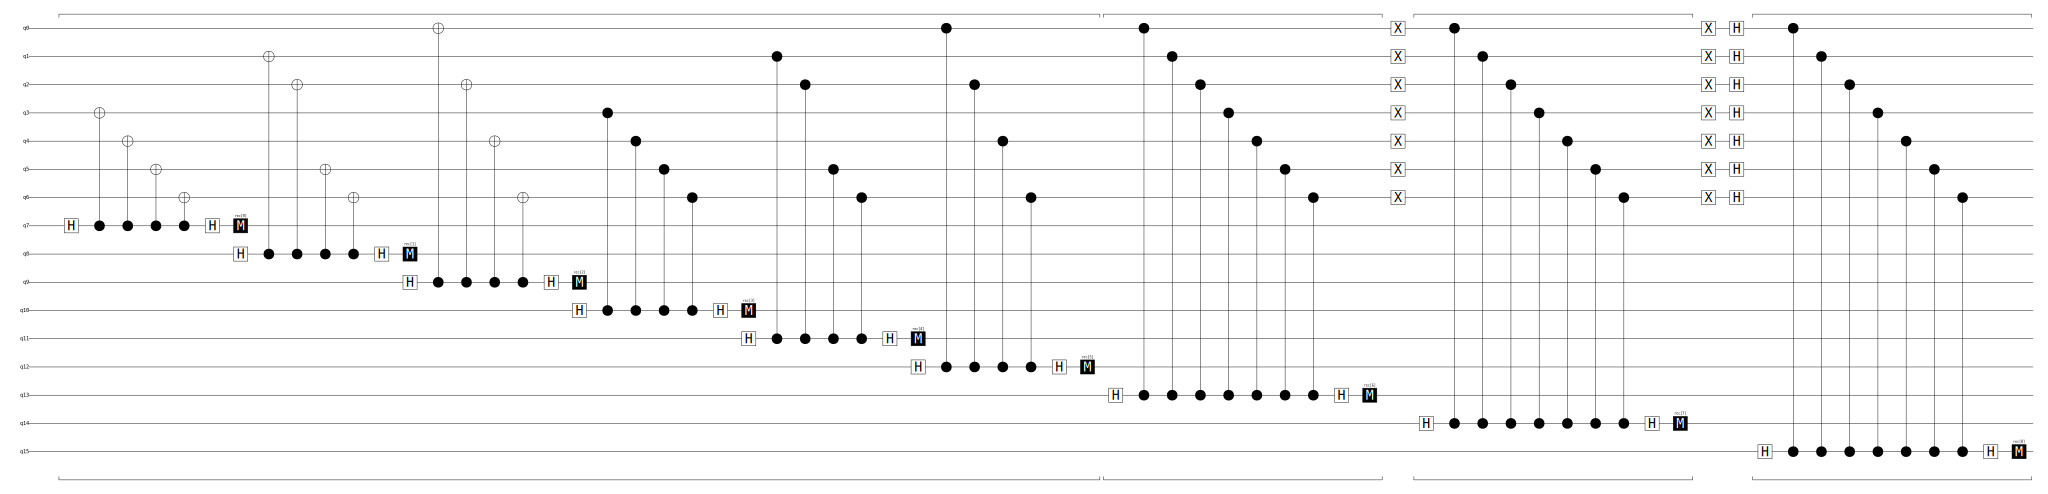

In [ ]:
circuit.diagram('timeline-svg')

In [ ]:
sampler = circuit.compile_sampler()
for i in range(0,20):
  print(1*sampler.sample(shots=1)[0][6:])
#we measure the logical 0,1 and + state in the logical Z basis

[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 1]
[0 1 0]
[0 1 0]
[0 1 1]
[0 1 1]
[0 1 1]
[0 1 1]
[0 1 0]
[0 1 1]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 0]
[0 1 1]


#Detectors and Noise

We are going to begin by lying about detectors.

Strictly speaking, each detector is just some binary function of some previous measurement outcomes. Usually, a detector exists to check if two bits have the same parity. Placing detectors in the circuit diagram can be misleading.

In [ ]:
circuit=stim.Circuit('''
R 0 1 2 3
H 0
CNOT 0 1
X_ERROR(0.3) 0 1
M 0 1  # These two measurements are always equal under noiseless execution.
# Annotate that the parity of the previous two measurements should be consistent.
DETECTOR rec[-1] rec[-2]

H 2
CNOT 2 3
X_ERROR(0.3) 2 3
M 2 3  # These two measurements are always equal under noiseless execution.
DETECTOR rec[-1] rec[-2]
''')

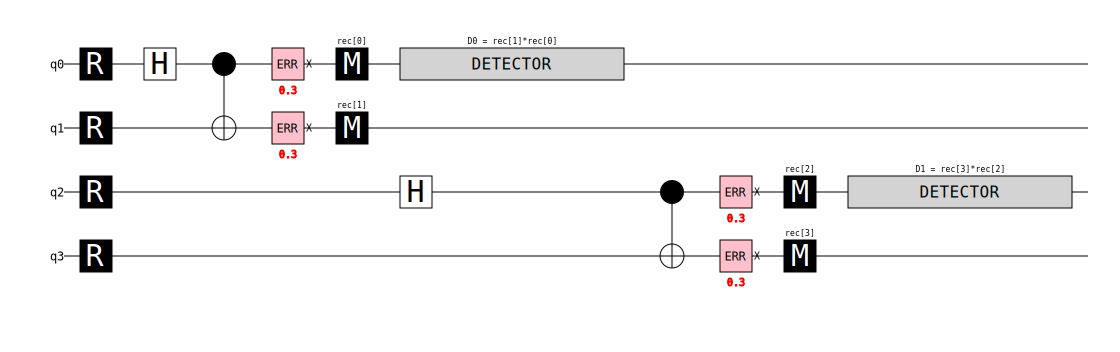

In [ ]:
circuit.diagram('timeline-svg')

The first part of the circuit prepares the bell state 00+11. When we measure the state in the Z basis, the parity of the two measurement should always be equal. The detector raises TRUE only if the parity is not equal. The detector will only spot certain errors, for example if the state is changed to 00-11 then this will not be detected.

In [ ]:
detector_sampler = circuit.compile_detector_sampler()
detector_sampler.sample(shots=10)

array([[False, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [False, False],
       [False,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False]])

For a quantum code, a detector is normall placed after each ancilla measurement, just to check if this ancilla measurement has changed since last time. If an error occurs, the detector will only flag it once, whereas repeated ancilla measurement would flag it every time.

In [ ]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.42) D0
    error(0.42) D1
''')


Stim has translated the cicuit into a set of detectors, and a set of errors that can set off the detectors.

Let's focus on the first detector. There are two errors that can affect this detector, which independently with probability 0.3. The detector is only flipped if exactly one occurs, the probability of which is 0.3*0.7*2=0.42. So stim traslates this whole thing into "I define an error E_1 which occurs with probability 0.42 and violates detector d_1.

So 4 errors+2 detectors is translated into 2 errors and 2 detectors. This information fed directly into a decoder.

In [ ]:
dem.diagram("matchgraph-svg")

Each node in the graph is a detector. Each edge in the graph is an error.

Every stim circuit can be translated into the "detector error model". This just specifies where errors can occurs, with what probability, and which detectors they affect. Importantly, this is all the information the decoder needs in order to solve the decoding problem.

# Decoding the code

Let us see how to use detectors and observables to try and decode the repetition code. Here is a premade repetition code circuit.

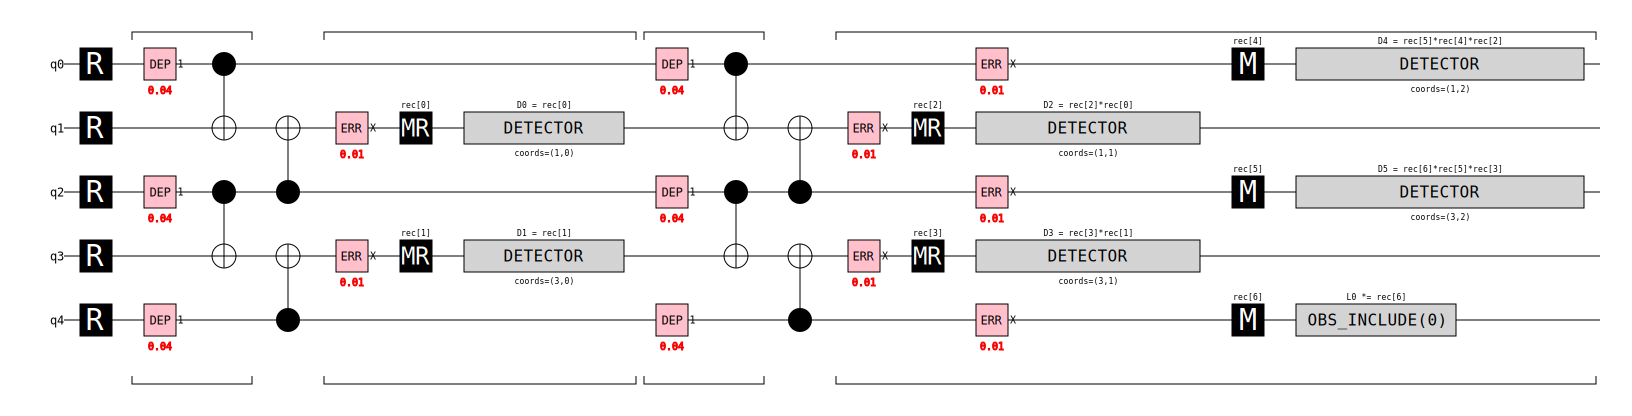

In [ ]:
circuit=stim.Circuit('''
    R 0 1 2 3 4
    TICK
    DEPOLARIZE1(0.04) 0 2 4
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    X_ERROR(0.01) 1 3
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    TICK
    DEPOLARIZE1(0.04) 0 2 4
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    X_ERROR(0.01) 1 3
    MR 1 3
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-4]
    DETECTOR(3, 0) rec[-1] rec[-3]
    X_ERROR(0.01) 0 2 4
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')
circuit.diagram('timeline-svg')

Let us break down the circuit into steps:


1.   The R gate prepares each physical qubit into the 0 state. qubits 0,2,4 are data, qubits 1,3 are ancilla
2.   We add some depolarising noise to each of the data qubits.
3. We perform some controlled operations between the data qubits and the ancilla qubits. This prepares the stabilizers measurement.
4. We add some X noise to the ancillas.
5. We measure each of the ancillas and get a syndrome. The MR gate measures in the Z basis and then re-prepares each ancilla in the 0 state.
6. We add a detector to each ancille which returns FALSE if 0 was measured and TRUE if 1 was measured.
7. We repeat 2-5. We then add another detector to each ancilla, which asks if the measurement outcome was the same as the previous detector. This can be confusing. Suppose the only error is XII before the first round. The ancilla measurement will record 1 both times, since the error anticommutes both times. However, only the first detector is triggered. A detector only triggers if we see an **unexpected** measurement. The ancilla measuring 1 the second time is not unexpected, so the detector doesn't trigger. This speeds things up. This can also be useful in state initialisation.  
8. So far we have 4 ancilla bits and 4 detector bits. We can transform ancilla bits into detector bits, which is all we need to pass to the decoder.
9. We measure the data qubit in the Z basis. This completely collapses the quantum state, which is normally what we do at the end of an algorithm.
10.

